![tutorial banner](images/PVLib_PVPMCLogo.PNG)


# Tutorial 3 - Modeling an Array Power with PVWatts

This notebook shows how to use pvlib to model an array's output power given POA irradiance and cell temperature.

The physics of a solar cell are fairly complex.  Models of a cell's response to light and temperature range from high-level approximations that need only one or two coefficients, to electrical circuit models that require more detailed cell characteristics, to full physics-based semiconductor models.  The level of detail should match the application -- first-order approximations can be surprisingly accurate but probably shouldn't be used for financial decisions, while physics-based semiconductor models are rarely practical outside of a laboratory setting.

We will model a system similar to one you might have or want to place on your house:

![Solar Array on House](images/t4_solarArrayHouse.PNG)

Photo from Mark's Grandma's House



## PVWatts

Here we will demonstrate one of the more basic PV models implemented by pvlib.  The PVWatts module model requires only two array parameters -- the array size (nameplate capacity) and the array's efficiency change with cell temperature.  Typical array sizes range from a few kW for residential arrays to hundreds of MW for large utility-scale systems.  The cell temperature response parameter, often called the module's temperature coefficient, determines the efficiency loss for a temperature increase.  For example, a module that produces 100W at test conditions but only 95W when the cell temperature is increased by 10 degrees has a temperature coefficient of -0.5%/°C.  Typical temperature coefficients range from -0.5%/°C to -0.2%/°C.

We'll read in weather data, run the irradiance transposition, and model cell temperature as in previous tutorials.


## STEPS:
<ol>
    <li><a id='step1'>Define System</a></li>
    <li><a id='step2'>Calculating the Temperature of the system </a></li>
    <li><a id='step3'>Calculating the Power (DC) </a></li>
    <li><a id='step4'>Calculating the AC Power </a></li>
</ol>

In [ ]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install -r https://raw.githubusercontent.com/PVSC-Python-Tutorials/PVPMC_2022/main/requirements.txt

<a href='#step1'>


## 1. Define system


In [1]:
import pvlib
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt  # for visualization
import pathlib  # for finding the example dataset

print(pvlib.__version__)

0.9.0


In [2]:
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, metadata = pvlib.iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)

location = pvlib.location.Location(latitude=metadata['latitude'],
                                   longitude=metadata['longitude'])

times = df_tmy.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
solar_position.index += pd.Timedelta('30min')


tilt = 20
azimuth = 180

array_poa = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,
                                                       surface_azimuth=azimuth,
                                                       dni=df_tmy['DNI'],
                                                       ghi=df_tmy['GHI'],
                                                       dhi=df_tmy['DHI'],
                                                       solar_zenith=solar_position['apparent_zenith'],
                                                       solar_azimuth=solar_position['azimuth'])
array_poa = array_poa['poa_global']  # Returns various irradiances; we will use the global value at plane of array.



<a href='#step2'>

## 2. Calculating the Temperature of the system

If PV modules were 100% efficient, they would convert 100% of collected irradiance into electrical energy. However, today's PV modules are on the order of 20% efficient, meaning that after accounting for reflection, soiling, spectral mismatch, and the glass, the other 80% of sunlight collected is converted to thermal energy. This thermal energy causes the temperature of the module to rise above ambient conditions, eventually reaching a steady state defined by a heat balance of power in (solar irradiance) vs power out (thermal radiation, convective cooling, etc). With that in mind, the primary drivers of module temperature are POA irradiance, ambient temperature, and wind speed.

A distinction that is often ignored is the difference between module temperature and cell temperature. In theory, the temperature of the P-N junction inside the cell is what affects conversion efficiency, but this is difficult to measure. In practice, the temperature of the module backsheet is often a usable approximation, though it is often 1-2 degrees Celsius cooler than the junction temperature.

Modeling module temperature
Some PV thermal models go to the trouble of modeling the entire heat balance equation, but much simpler models are available and are often accurate enough. Here we will use the thermal model from the Sandia Array Performance Model (SAPM) to estimate cell temperature from ambient conditions. The SAPM thermal model takes only POA irradiance, ambient temperature, and wind speed as weather inputs, but it also requires a set of parameters that characterize the thermal properties of the module of interest. Pvlib has common literature values, and we will access those for a common racking format.

In [3]:
parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
cell_temperature = pvlib.temperature.sapm_cell(array_poa,
                                               df_tmy['DryBulb'],
                                               df_tmy['Wspd'],
                                               **parameters)

If we wanted to use other parameters, here are the options

In [4]:
all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
list(all_parameters.keys())

['open_rack_glass_glass',
 'close_mount_glass_glass',
 'open_rack_glass_polymer',
 'insulated_back_glass_polymer']

Now let's compare ambient temperature with cell temperature.  Notice how our modeled cell temperature rises significantly above ambient temperature during the day, especially on sunny days:

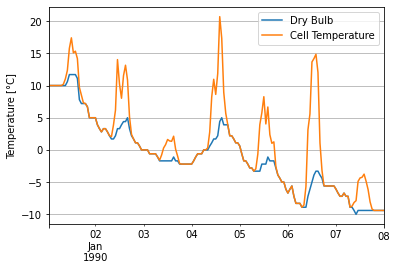

In [5]:
df_tmy['DryBulb'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.grid()
plt.legend(['Dry Bulb', 'Cell Temperature'])
# note Python 3 can use unicode characters like the degrees symbol
plt.ylabel('Temperature [°C]');

<a href='#step3'>

## 3. Calculating the Power (DC)

For demonstration purposes, we'll assume a 1kW array with a temperature coefficient of -0.4%/°C:

In [6]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
nameplate = 1000 # Watts

array_power = pvlib.pvsystem.pvwatts_dc(array_poa, cell_temperature, nameplate, gamma_pdc)

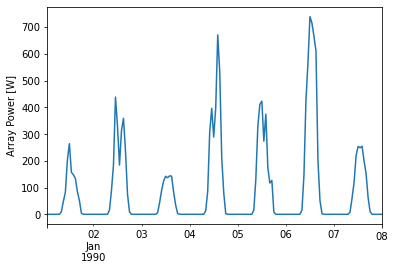

In [7]:
array_power.head(24*7).plot()
plt.ylabel('Array Power [W]');

Let's take a look at the array's response to irradiance and temperature:

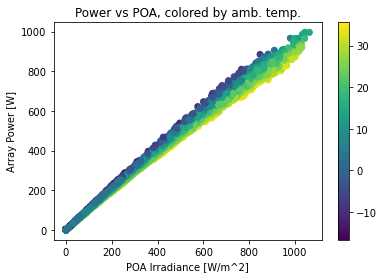

In [8]:
plt.scatter(array_poa, array_power, c=df_tmy['DryBulb'])
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by amb. temp.');

This plot shows a strong, near-linear trend of power with POA irradiance.  However, it also shows a performance change with temperature -- as ambient temperature increases, array output drops.  The gradient is smoother if we color by cell temperature:

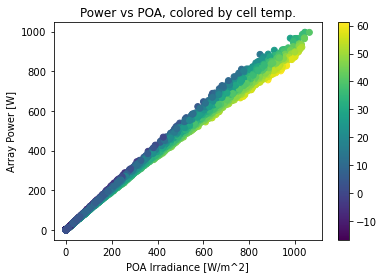

In [9]:
plt.scatter(array_poa, array_power, c=cell_temperature)
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by cell temp.');

We can also compare with a hypothetical module with a smaller temperature coefficient, which shows a correspondingly smaller temperature effect:

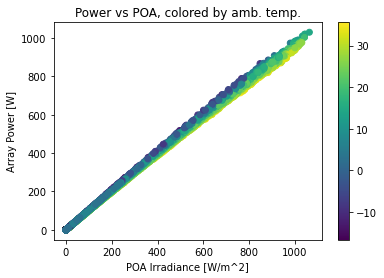

In [10]:
array_power_low_tempco = pvlib.pvsystem.pvwatts_dc(array_poa, cell_temperature, nameplate, -0.002)
plt.scatter(array_poa, array_power_low_tempco, c=df_tmy['DryBulb'])
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by amb. temp.');

Another way of viewing the temperature effect is to compare monthly energy production with monthly POA insolation, noticing how production dips relative to insolation in the summertime. 

Text(0, 0.5, 'Energy [Wh]')

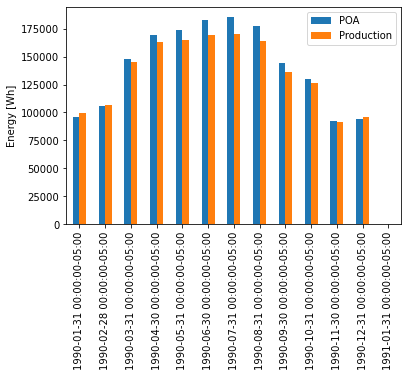

In [11]:
df_plot = pd.DataFrame({
    'POA': array_poa,
    'Production': array_power,
})
# summing hourly power (W) gives (W h)
df_plot.resample('M').sum().plot.bar()
plt.ylabel('Energy [Wh]')

<a href='#step4'>

## 4. Calculating the AC Power 

PVWatts has a simplified inverter model. Use [`pvlib.inverter.pvwatts(pdc, pdc0)`](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.inverter.pvwatts.html) to return the AC output given DC output, `pdc`, and the DC limit, `pdc0` which is the AC rated power over the nominal inverter efficiency.

Recall we assumed a 1kW array, so we'll continue the hypothetical case and assume an AC size of 800W, a DC/AC ratio of 1.2. The default PVWatts nominal inverter efficiency is 0.96 which we use to get `pdc0`.

In [12]:
pdc0 = 800/0.96  # W
ac = pvlib.inverter.pvwatts(array_power, pdc0)

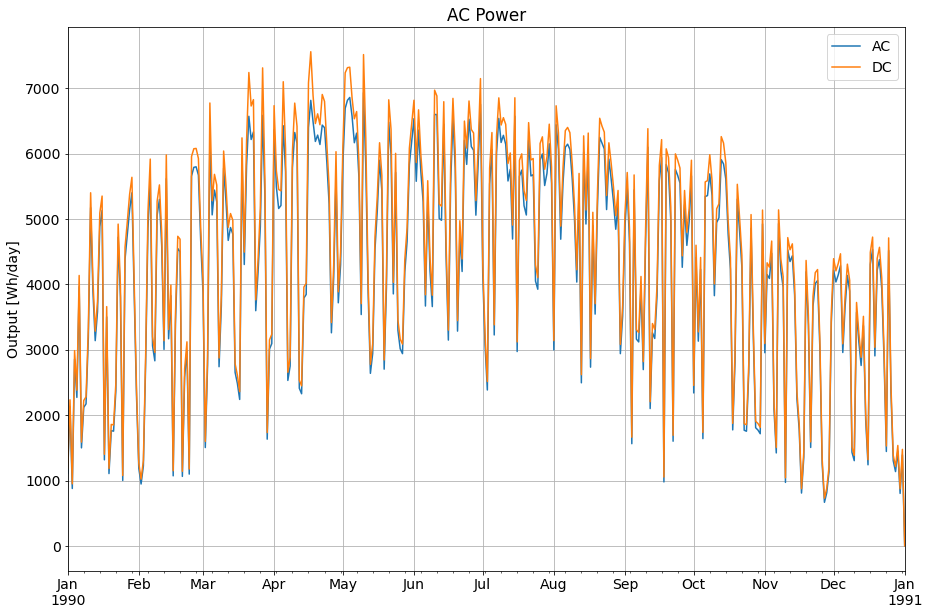

In [13]:
plt.rcParams['font.size'] = 14
ax = ac.resample('D').sum().plot(figsize=(15, 10), label='AC')
array_power.resample('D').sum().plot(ax=ax, label='DC')
plt.title('AC Power')
plt.ylabel('Output [Wh/day]')
plt.grid()
plt.legend()

## Go Bigger: Utility tracking Systems

Tracker systems follow the sun, and they are the norm on new utility scale installations. PVlib also allows to model tracker systems, just replace the tilt and azimuth data for the one calculated for single axis tracking 


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).